In [35]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression
from sklearn.cross_validation import train_test_split


%matplotlib notebook


In [2]:
boardgames = pd.read_csv('../scrapers/boardgamegeek/games.csv')

In [3]:
boardgames['average_rating'].sample(5)

51359    8.33333
33933    8.00000
26677    2.00000
28351    6.66667
34827    4.00000
Name: average_rating, dtype: float64

In [4]:
boardgames.dropna(axis=0,inplace=True)
boardgames = boardgames[(boardgames['users_rated'] != 0)]

<IPython.core.display.Javascript object>


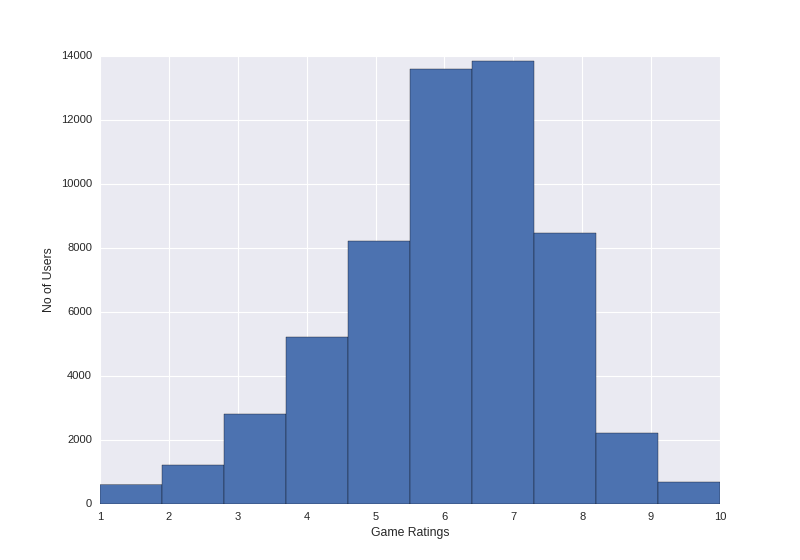

In [5]:
plt.figure(figsize=(10,7))
plt.xlim((1,10))
plt.xlabel('Game Ratings')
plt.ylabel('No of Users')
boardgames.average_rating.hist(bins=10);

plt.show()

In [6]:
print('Average_rating standard dev: {0:.3f}'.format(boardgames.average_rating.std()))
print('Average_rating mean : {0:.3f}'.format(boardgames.average_rating.mean()))
print('Average_rating median : {0:.3f}'.format(boardgames.average_rating.median()))

Average_rating standard dev: 1.579
Average_rating mean : 6.016
Average_rating median : 6.150


# Picking an error metric:

- The average rating column contains continuous values.
- Choosing a regression based metric.
- The histogram 'looks' Gaussian.
- So picking Mean squared error as it the easiest one to start with.
- Referring to the [sklearn regression metrics help] for more info.

[sklearn regression metrics help]:http://scikit-learn.org/stable/modules/model_evaluation.html#regression-metrics

# Clustering with KMeans:

### Steps:
- Filtering out non-numerical values from the DataFrame.
- Next step is to find the cluster the'distances' between rows of numerical data.
- Picking 10 clusters, one for each rating value.
- Fitting the [KMeans] model to obtain the cluster labels.
- Finding the mean and standard deviation of each row.
- Plotting the clusters.

[KMeans]:http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html

In [7]:
#Filtering 

print(boardgames.dtypes != object)

                    #Excluding id column
filtered_columns = boardgames.columns[1:].to_series()[boardgames.dtypes != object]
numeric_columns = boardgames[filtered_columns]
numeric_columns.head(3)

id                       True
type                    False
name                    False
yearpublished            True
minplayers               True
maxplayers               True
playingtime              True
minplaytime              True
maxplaytime              True
minage                   True
users_rated              True
average_rating           True
bayes_average_rating     True
total_owners             True
total_traders            True
total_wanters            True
total_wishers            True
total_comments           True
total_weights            True
average_weight           True
dtype: bool


,yearpublished,minplayers,maxplayers,playingtime,minplaytime,maxplaytime,minage,users_rated,average_rating,bayes_average_rating,total_owners,total_traders,total_wanters,total_wishers,total_comments,total_weights,average_weight
0,2005.0,2.0,2.0,180.0,180.0,180.0,13.0,20113,8.33774,8.22186,26647,372,1219,5865,5347,2562,3.4785
1,2012.0,2.0,5.0,150.0,60.0,150.0,12.0,14383,8.28798,8.14232,16519,132,1586,6277,2526,1423,3.8939
2,2013.0,1.0,7.0,210.0,30.0,210.0,12.0,9262,8.28994,8.06886,12230,99,1476,5600,1700,777,3.7761


In [8]:
kmeans_model = KMeans(n_clusters=10)

In [9]:
kmeans_model.fit(numeric_columns)

KMeans(copy_x=True, init='k-means++', max_iter=300, n_clusters=10, n_init=10,
    n_jobs=1, precompute_distances='auto', random_state=None, tol=0.0001,
    verbose=0)

In [10]:
labels = kmeans_model.labels_
labels.shape

(56894,)

In [11]:
game_mean = numeric_columns.mean(axis=1)
game_std = numeric_columns.std(axis=1)

In [12]:
game_mean.shape

(56894,)

# Matplotlib plotting with legend:

https://stackoverflow.com/questions/26558816/matplotlib-scatter-plot-with-legend#26559256

<IPython.core.display.Javascript object>


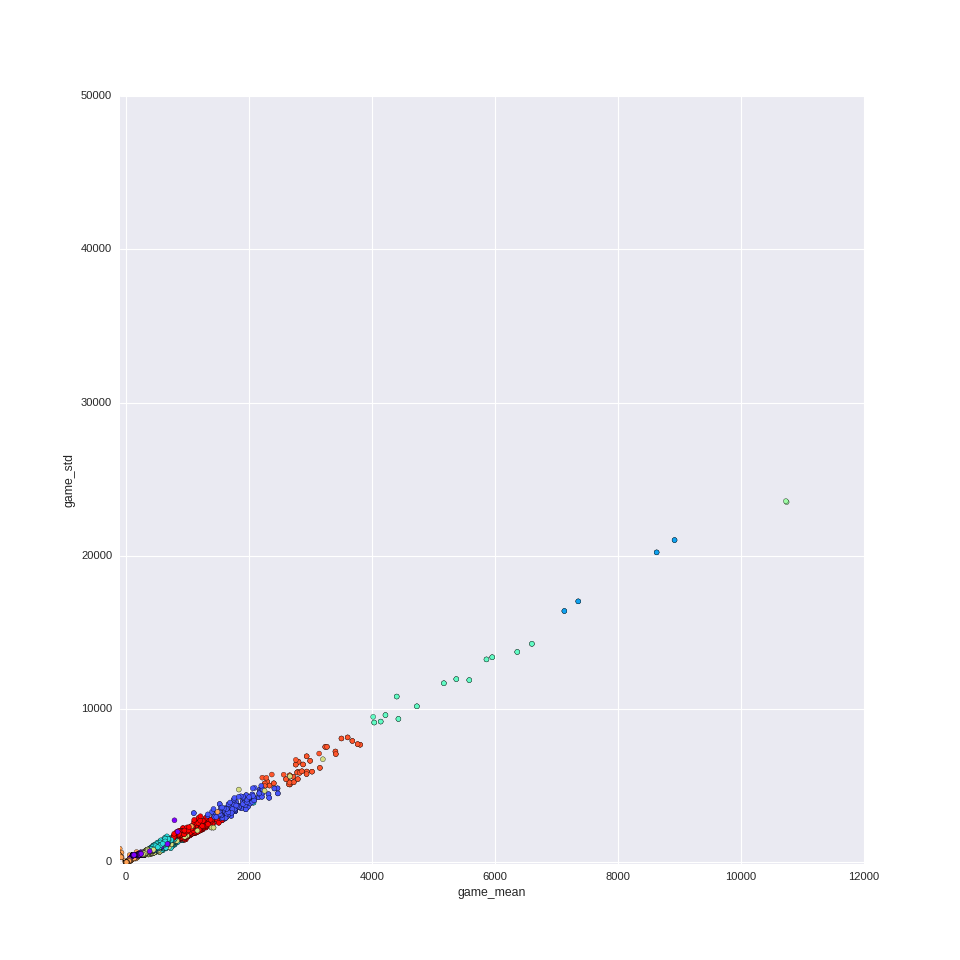

In [13]:
rating_labels = list(np.unique(labels))

plt.figure(figsize=(12,12))
plt.xlim((-100,12000))
plt.ylim((-100,50000))
plt.xlabel('game_mean')
plt.ylabel('game_std')
plt.scatter(game_mean,game_std,c=labels,cmap='rainbow')
plt.show()

# Notes: 

- The <em>user_rated</em> and <em>yearpublished</em> columns are relatively large compared to other values.
- Larger the user base larger the game_mean value and consequently larger game_std value.
- This means that games with larger user base will have a greater mean value and standard deviation.



In [14]:
l = numeric_columns.columns.tolist()
l.remove('bayes_average_rating')
correlations = numeric_columns[l].corr()

In [15]:
print(correlations.average_rating)

yearpublished     0.108461
minplayers       -0.032701
maxplayers       -0.008335
playingtime       0.048994
minplaytime       0.043985
maxplaytime       0.048994
minage            0.210049
users_rated       0.112564
average_rating    1.000000
total_owners      0.137478
total_traders     0.119452
total_wanters     0.196566
total_wishers     0.171375
total_comments    0.123714
total_weights     0.109691
average_weight    0.351081
Name: average_rating, dtype: float64


# Notes:

- The <em>average_weight</em> column depicting [subjective weights] has the highest correlation.
- The <em>total_*</em> columns have a high correlations with average rating. 
- Owners, wanters and wishers of a game to have relatively high correlation with the <em>average rating</em>.
- The <em>minage</em> column has a surprisingly high correlation. This might indicate an age bias in the dataset.

[subjective weights]:https://boardgamegeek.com/wiki/page/Weight


In [16]:
reg = LinearRegression()

In [36]:
l = numeric_columns.columns.tolist()
l.remove('bayes_average_rating')
l.remove('minplayers')
l.remove('maxplayers')
l.remove('minplaytime')
l.remove('maxplaytime')
l.remove('average_rating')
#data = numeric_columns[l]
data = numeric_columns[l]

In [43]:
X_tr, X_test, y_tr ,y_test = train_test_split(data,numeric_columns.average_rating,test_size=0.7,random_state=123)

In [44]:
reg.fit(X_tr,y_tr)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [47]:
predictions = reg.predict(X_test)

In [49]:
predictions.shape

(39826,)

In [60]:
mse = mean_squared_error(y_test,predictions)
print("Mean square error : {0:.3f}".format(mse))

Mean square error : 2.109


In [61]:
print("Standard deviation of Average ratings: {0:.3f}".format(numeric_columns['average_rating'].std()))

Standard deviation of Average ratings: 1.579


# Note: 

- The Standard deviation of the Average Ratings(y_true) from the dataset has is close to the Mean Square Error of the model. 
- This means that any predictions we make using the model may well fall within the standard deviation of the data.